# NLP - Text Classification  

**NLP model given a set of text movie reviews that have been labeled negative or positive**

For more information on this dataset visit http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../DATA/moviereviews.csv')

In [3]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


In [4]:
# Check for NaN values:
df.isnull().sum()

label      0
review    35
dtype: int64

In [5]:
# Remove NaN values:
df = df.dropna()

In [6]:
# Remove blank strings ("" or " " or other larger blank string)
df['review'].str.isspace().sum()

27

In [7]:
df = df[~df['review'].str.isspace()]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1938 non-null   object
 1   review  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [9]:
# Confirm the value counts per label
df['label'].value_counts()

label
neg    969
pos    969
Name: count, dtype: int64

In [10]:
# Text data is in a column named 'review'
text_column = 'review'

# Tokenize the text into words
words = df[text_column].str.split().explode()

# Count the number of unique words
num_unique_words = len(words.unique())

# Print the result
print("Number of unique words:", num_unique_words)

Number of unique words: 49827


## EDA on Bag of Words

Used a CountVectorizer model to get the top 20 words (that are not english stop words) per label type

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
cv = CountVectorizer(stop_words='english')

In [13]:
# top 20 words (not stop words) per Negative reviews

matrix = cv.fit_transform(df[df['label']=='neg']['review'])
freqs = zip(cv.get_feature_names(), matrix.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print("Top 20 words used for Negative reviews.")
print(sorted(freqs, key=lambda x: -x[1])[:20])

Top 20 words used for Negative reviews.
[('film', 4063), ('movie', 3131), ('like', 1808), ('just', 1480), ('time', 1127), ('good', 1117), ('bad', 997), ('character', 926), ('story', 908), ('plot', 888), ('characters', 838), ('make', 813), ('really', 743), ('way', 734), ('little', 696), ('don', 683), ('does', 666), ('doesn', 648), ('action', 635), ('scene', 634)]


In [14]:
# top 20 words (not stop words) per Positive reviews

matrix = cv.fit_transform(df[df['label']=='pos']['review'])
freqs = zip(cv.get_feature_names(), matrix.sum(axis=0).tolist()[0])    
# sort from largest to smallest
print("Top 20 words used for Positive reviews.")
print(sorted(freqs, key=lambda x: -x[1])[:20])

Top 20 words used for Positive reviews.
[('film', 5002), ('movie', 2389), ('like', 1721), ('just', 1273), ('story', 1199), ('good', 1193), ('time', 1175), ('character', 1037), ('life', 1032), ('characters', 957), ('way', 864), ('films', 851), ('does', 828), ('best', 788), ('people', 769), ('make', 764), ('little', 751), ('really', 731), ('man', 728), ('new', 702)]


### Training and Data

In [15]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Training a Mode

Created a PipeLine that creates a TF-IDF Vector out of the raw text data and fit a supervised learning model of any choice. Then fitted that pipeline on the training data.

Here I used LinearSVC and MultinomialNB

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

### TF-IDF + Linear SVC 

In [17]:
# TF-IDF + Linear SVC + RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline with TfidfVectorizer and LinearSVC
pipe_linearSVC = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC(max_iter=10000))
])

# Define the hyperparameters and their possible values for the randomized search
param_dist_linearSVC = {
    'tfidf__max_features': [3000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1, 10, 100]
}

# Create the RandomizedSearchCV object
random_search_linearSVC = RandomizedSearchCV(pipe_linearSVC, param_distributions=param_dist_linearSVC, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model to the data
random_search_linearSVC.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("LinearSVC Best Parameters: ", random_search_linearSVC.best_params_)
print("LinearSVC Best Accuracy: {:.2f}".format(random_search_linearSVC.best_score_))

LinearSVC Best Parameters:  {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 5000, 'svc__C': 1}
LinearSVC Best Accuracy: 0.85


### TF-IDF + Multinomial Naive Bayes

In [18]:
# TF-IDF + Multinomial Naive Bayes + RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline with TfidfVectorizer and MultinomialNB
pipe_NB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define the hyperparameters and their possible values for the randomized search
param_dist_NB = {
    'tfidf__max_features': [3000, 5000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1, 2]
}

# Create the RandomizedSearchCV object
random_search_NB = RandomizedSearchCV(pipe_NB, param_distributions=param_dist_NB, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model to the data
random_search_NB.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("MultinomialNB Best Parameters: ", random_search_NB.best_params_)
print("MultinomialNB Best Accuracy: {:.2f}".format(random_search_NB.best_score_))

MultinomialNB Best Parameters:  {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': None, 'nb__alpha': 0.1}
MultinomialNB Best Accuracy: 0.84


In [19]:
best_model_SV = random_search_linearSVC.best_estimator_
best_model_NB = random_search_NB.best_estimator_

Created a classification report and plotted a confusion matrix based on the results of randomized search cv

In [20]:
from sklearn.metrics import classification_report,plot_confusion_matrix

In [21]:
preds_sv = best_model_SV.predict(X_test)
preds_nb = best_model_NB.predict(X_test)

In [22]:
print("Linear Support Vector:")
print(classification_report(y_test,preds_sv))

Linear Support Vector:
              precision    recall  f1-score   support

         neg       0.80      0.86      0.83       191
         pos       0.86      0.80      0.83       197

    accuracy                           0.83       388
   macro avg       0.83      0.83      0.83       388
weighted avg       0.83      0.83      0.83       388



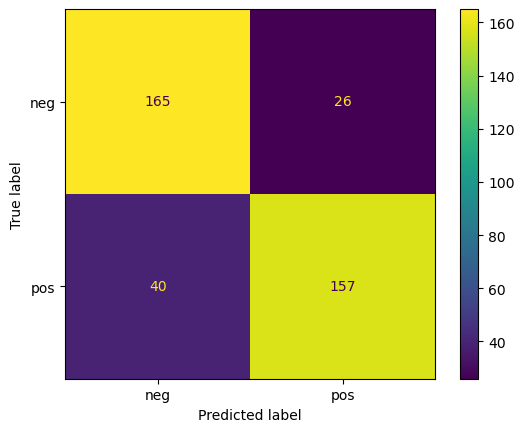

In [23]:
plot_confusion_matrix(best_model_SV,X_test,y_test)

In [24]:
print("Multinomial Naive Bayes:")
print(classification_report(y_test,preds_nb))

Multinomial Naive Bayes:
              precision    recall  f1-score   support

         neg       0.83      0.82      0.83       191
         pos       0.83      0.84      0.83       197

    accuracy                           0.83       388
   macro avg       0.83      0.83      0.83       388
weighted avg       0.83      0.83      0.83       388



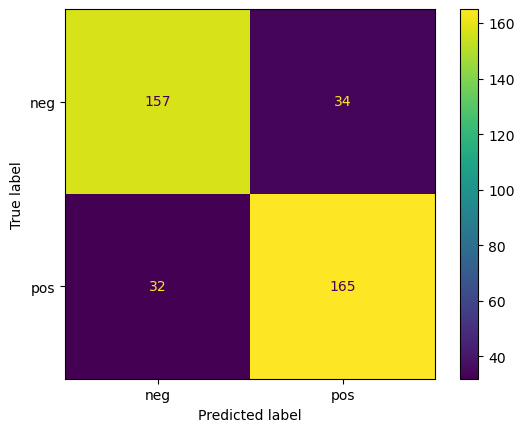

In [25]:
plot_confusion_matrix(best_model_NB,X_test,y_test)

### Prediction 

In [28]:
new_review = ['good movie']
best_model_SV.predict(new_review)

array(['pos'], dtype=object)

In [29]:
new_review = ['bad movie']
best_model_SV.predict(new_review)

array(['neg'], dtype=object)

In [31]:
new_review = ['okay movie']
best_model_SV.predict(new_review)

array(['neg'], dtype=object)

### Note

**CountVectorizer:**

CountVectorizer is used to convert a collection of text documents to a matrix of token counts. Each row in the matrix represents a document, and each column represents a unique word in the entire set of documents. The value in each cell represents the count of the corresponding word in the document.

**TfidfTransformer:**

TfidfTransformer is used to transform a count matrix obtained from CountVectorizer into a term-frequency or term-frequency times inverse document-frequency (TF or TF-IDF) representation.

**TfidfVectorizer = CountVectorizer + TfidfTransformer **

TfidfVectorizer combines the functionality of CountVectorizer and TfidfTransformer into a single step. It converts a collection of raw documents to a matrix of TF-IDF features.

**Process**

1. Text Cleaning:
       
        Removing special characters, punctuation, and numbers.
        Converting text to lowercase.
        Removing stop words (common words like "the," "and," etc. that do not contribute much to the meaning).

2. Tokenization:

3. Stemming and Lemmatization:

        Example:
        Stemming: "running" → "run"
        Lemmatization: "better" → "good"

4. Vectorization:

        In order to apply machine learning algorithms to text data, it needs to be converted into a numerical format. Vectorization involves representing words or phrases as vectors of numerical values. The two common techniques for vectorization are:
        
        1. Bag-of-Words (BoW): Represents each document as a vector of word frequencies.
        
        2. Term Frequency-Inverse Document Frequency (TF-IDF): Reflects the importance of words by considering their frequency in a document and across multiple documents.

5. Feature Engineering:

       This can include creating features such as n-grams, sentiment scores, or other linguistic features.

6. Model Building:

       With the processed and vectorized text data, it can be used to train machine learning models for various NLP tasks, such as sentiment analysis, text classification, named entity recognition, machine translation, and more. 
        
       Common algorithms include support vector machines, naive Bayes, recurrent neural networks (RNNs), and transformer models.